# RNN for path-dependent plasticity

[Reference](https://doi.org/10.1016/j.jmps.2020.103972):
Gorji, M. B., Mozaffar, M., Heidenreich, J. N., Cao, J., & Mohr, D. (2020). On the potential of recurrent neural networks for modeling path dependent plasticity. *Journal of the Mechanics and Physics of Solids*, 143, 103972.

Plasticity model: Anisotropic Yld2000-2d with homogeneous anisotropic hardening

ML model: Gated recurrent units (GRU) + fully-connected layer (for plane stress only?)

### FCNN model for UT with reveral loading

In [8]:
import numpy as np
import pandas as pd

def interpolate(xin, yin, npt=1000, reverse=False):

    strain = np.linspace(min(xin), max(xin), 1000) if not reverse else np.linspace(max(xin), min(xin), npt)
    stress = np.interp(strain, xin, yin) if not reverse else np.interp(strain, xin[::-1], yin[::-1])

    return strain, stress

def get_ss_data(cols='F:K', sheet='UT 0.05', excel_fpath = "Reproduction_Mohr_2020_JMPS.xlsx", header=9):

    df = pd.read_excel(excel_fpath, sheet_name=sheet, header=header, usecols=cols)
    E = 201000  # MPa
    sig_y = 127.63  # MPa

    df['RF2'] = df['RF2 Node 3'] + df['RF2 Node 4']
    df['U2'] = df['U2 Node 3']

    df['strain_true'] = np.log(1+df['U2'])
    df['stress_true'] = df['RF2'] * (1+df['U2'])
    df['strain_plastic'] = df['strain_true'] - df['stress_true'] / E

    ind_yield = df[df['stress_true']>=sig_y].index[0]

    df_yield = df.iloc[ind_yield:]
    return df_yield

def interpolate_ss_data(df_data):
    ind_max = df_data['stress_true'].idxmax()
    strain1, stress1 = interpolate(df_data['strain_plastic'][:ind_max+1], df_data['stress_true'][:ind_max+1])
    strain2, stress2 = interpolate(df_data['strain_plastic'][ind_max:],   df_data['stress_true'][ind_max:], reverse=True)
    strain = np.concatenate((strain1, strain2))
    stress = np.concatenate((stress1, stress2))
    strain_inc = np.diff(strain)
    strain_sum = np.cumsum(abs(strain_inc))
    strain_sum = np.concatenate(([0], strain_sum))  # Add zero at the beginning
    return strain_sum, strain, stress

(2000,) (2000,) (2000,)
(2000,) (2000,) (2000,)
(2000,) (2000,) (2000,)
(6000,) (6000,) (6000,)


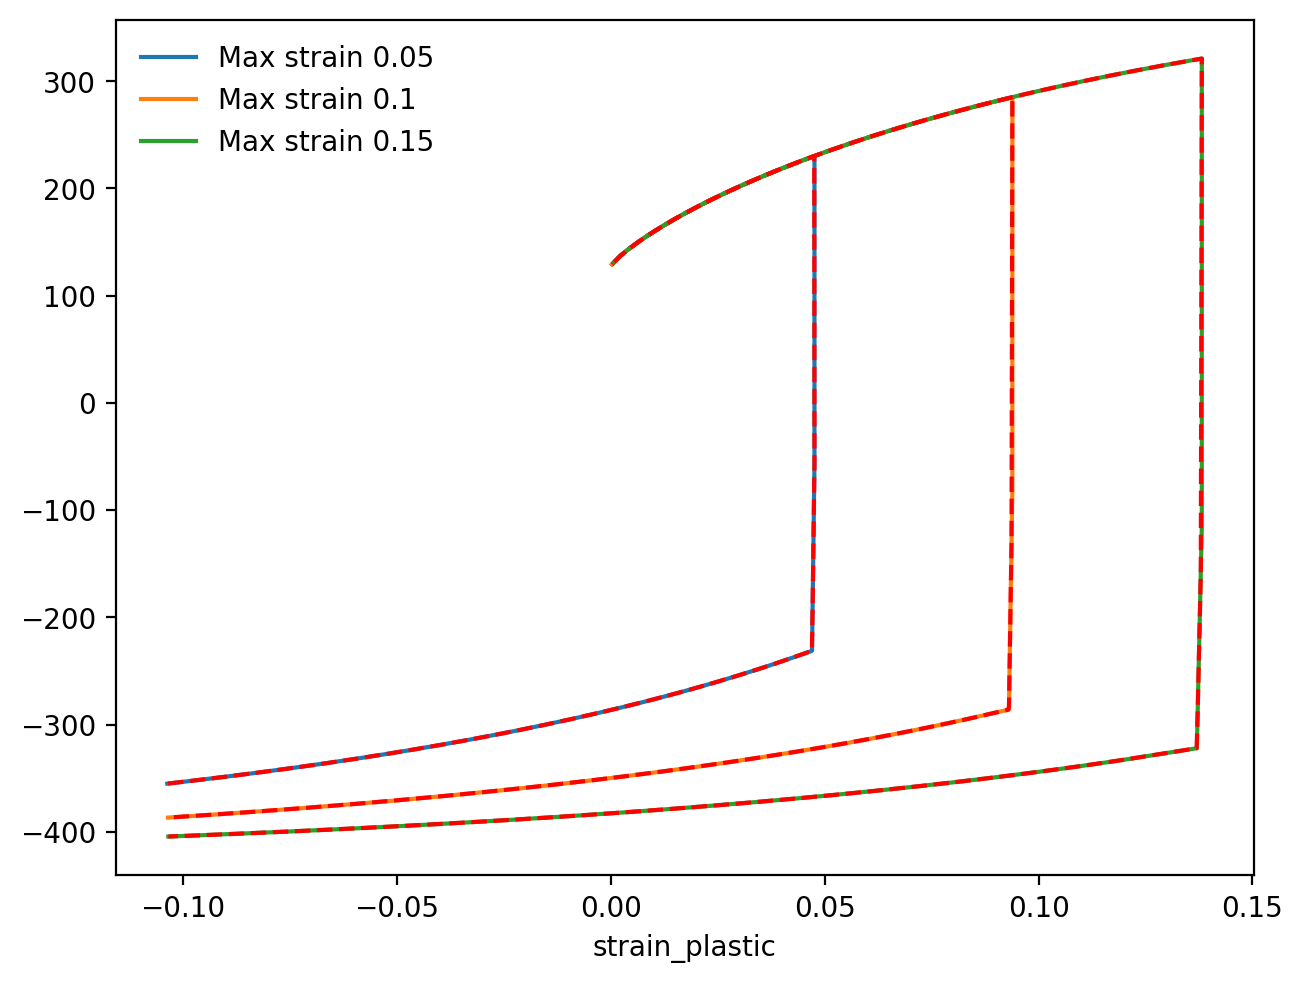

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
data = {}
strain_sum, strain, stress = np.array([]), np.array([]), np.array([])
for eps in [0.05, 0.1, 0.15]:
    data[eps] = get_ss_data(sheet=f'UT {eps}')

    strain_sum_int, strain_int, stress_int = interpolate_ss_data(data[eps])

    # ax.plot(strain, stress, label=f'Max strain {strain}')
    data[eps].plot(x='strain_plastic', y='stress_true', ax=ax, label=f'Max strain {eps}')
    ax.plot(strain_int, stress_int, label='Interpolated', color='r', linestyle='--')

    strain_sum = np.concatenate((strain_sum, strain_sum_int))
    strain = np.concatenate((strain, strain_int))
    stress = np.concatenate((stress, stress_int))
    print(strain_sum_int.shape, strain_int.shape, stress_int.shape)

labels, handles = ax.get_legend_handles_labels()
ax.legend(labels[::2], handles[::2], frameon=False)

print(strain_sum.shape, strain.shape, stress.shape)


#### Define the model architecture

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

class Net(nn.Module):

    def __init__(self, n_hl, n_npl):
        super(Net, self).__init__()
        self.nn_stack = nn.Sequential(
            # nn.BatchNorm1d(2),
            nn.Linear(2, n_npl),
            nn.Tanh(),
            *[nn.Sequential(nn.Linear(n_npl, n_npl), nn.Tanh()) for _ in range(n_hl)],
            nn.Linear(n_npl, 1)
        )

    def forward(self, input):
        # input[:,0] = (input[:,0] - np.mean(input[:,0])) / (max(input[:,0]) - min(input[:,0]))
        # input[:,1] = (input[:,1] - np.mean(input[:,1])) / (max(input[:,1]) - min(input[:,1]))
        output = self.nn_stack(input)
        return output

def train(X, y, batch_size, model, loss_fn, optimizer):

    size = len(X)
    model.train()
    X, y = shuffle(X, y)
    X_batch = torch.tensor(X, dtype=torch.float32).view(-1, batch_size, 2)
    y_batch = torch.tensor(y, dtype=torch.float32).view(-1, batch_size, 1)
    size = len(X_batch)
    train_loss = 0
    for batch, (X, y) in enumerate(zip(X_batch, y_batch)):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= size
    print('Training loss:', train_loss)
    return train_loss

def test(X, y, model, loss_fn):
    size = len(X)
    model.eval()
    # test_loss = 0
    X_batch = torch.tensor(X, dtype=torch.float32)
    y_batch = torch.tensor(y, dtype=torch.float32)
    with torch.no_grad():
        pred = model(X_batch.to(device))
        test_loss = loss_fn(pred, y_batch.to(device)).item()

    # test_loss /= size
    print(f'Test loss: {test_loss:>8f} \n')
    return test_loss


Using cuda device


In [22]:
from sklearn.model_selection import train_test_split

model = Net(n_hl=2, n_npl=20).to(device)
print(model)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-2)
epochs = 5000
batch_size = 40
train_loss, test_loss = [], []
strain_inp = np.vstack((strain, strain_sum)).T
x_train, x_test, y_train, y_test = train_test_split(strain_inp, stress, train_size=0.8)

for t in range(epochs):
    print(f'Epoch {t+1}-------------------------------')
    train_loss.append(train(x_train, y_train, batch_size, model, loss_fn, optimizer))
    test_loss.append(test(x_test, y_test, model, loss_fn))
print('Training done!')

Net(
  (nn_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Epoch 1-------------------------------
Training loss: 84034.51126302083
Test loss: 86086.625000 

Epoch 2-------------------------------


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1200])) that is different to the input size (torch.Size([1200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 83991.10221354167
Test loss: 86028.000000 

Epoch 3-------------------------------
Training loss: 83936.82513020834
Test loss: 85951.156250 

Epoch 4-------------------------------
Training loss: 83862.34231770833
Test loss: 85842.921875 

Epoch 5-------------------------------
Training loss: 83756.32516276042
Test loss: 85689.593750 

Epoch 6-------------------------------
Training loss: 83611.0650390625
Test loss: 85486.367188 

Epoch 7-------------------------------
Training loss: 83431.3998046875
Test loss: 85247.007812 

Epoch 8-------------------------------
Training loss: 83232.9109375
Test loss: 84991.257812 

Epoch 9-------------------------------
Training loss: 83030.44759114583
Test loss: 84734.171875 

Epoch 10-------------------------------
Training loss: 82832.22942708334
Test loss: 84482.515625 

Epoch 11-------------------------------
Training loss: 82642.04036458333
Test loss: 84240.968750 

Epoch 12-------------------------------
Training loss: 82463.45

Text(0, 0.5, 'Test loss [${MPa}^2$]')

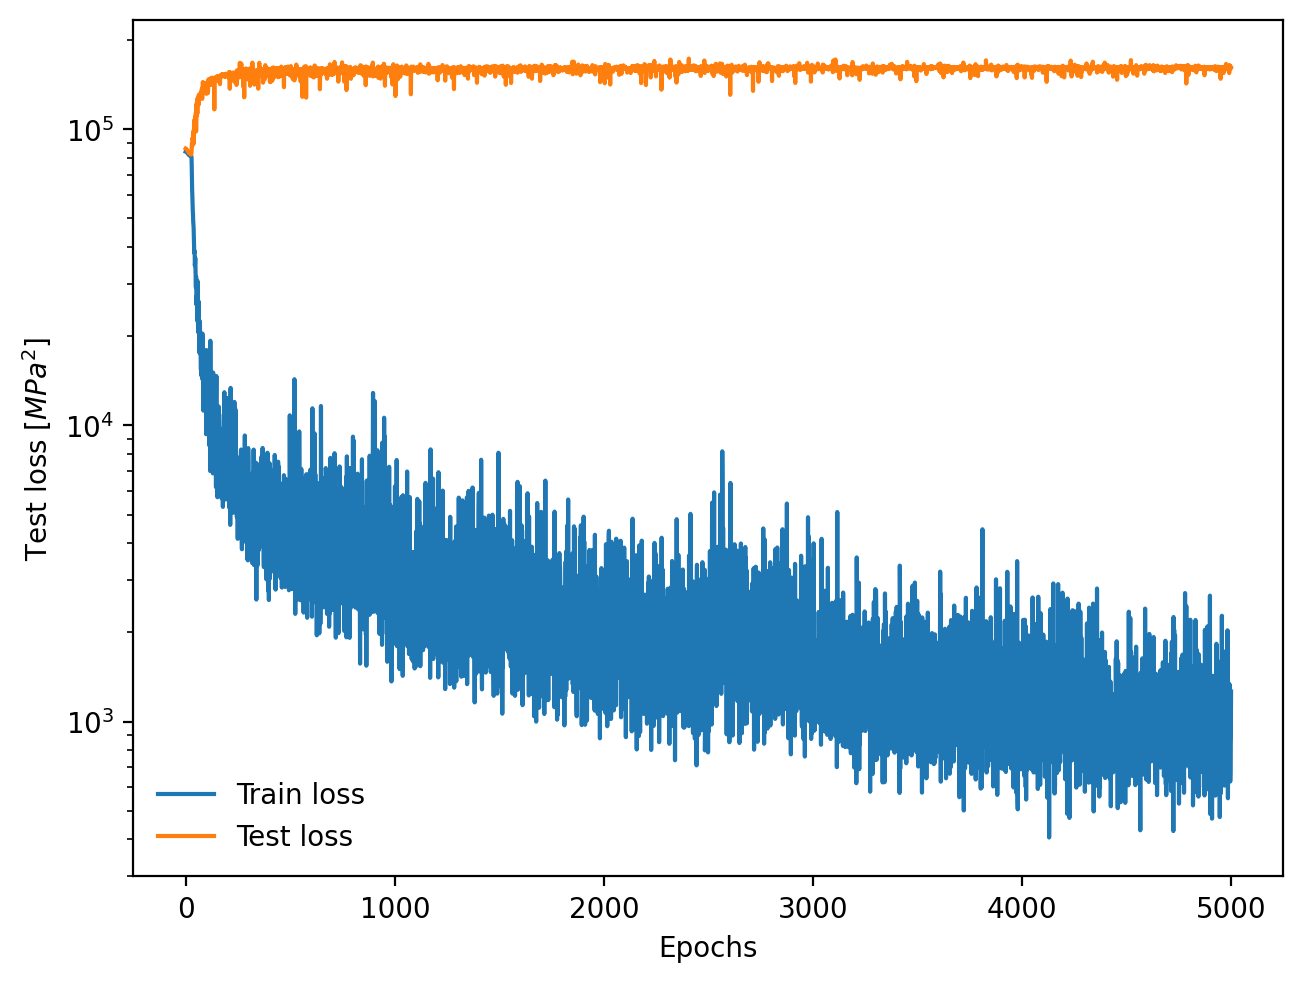

In [23]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.set_ylabel('Test loss [${MPa}^2$]')


Compare SS curve in FEA and ML

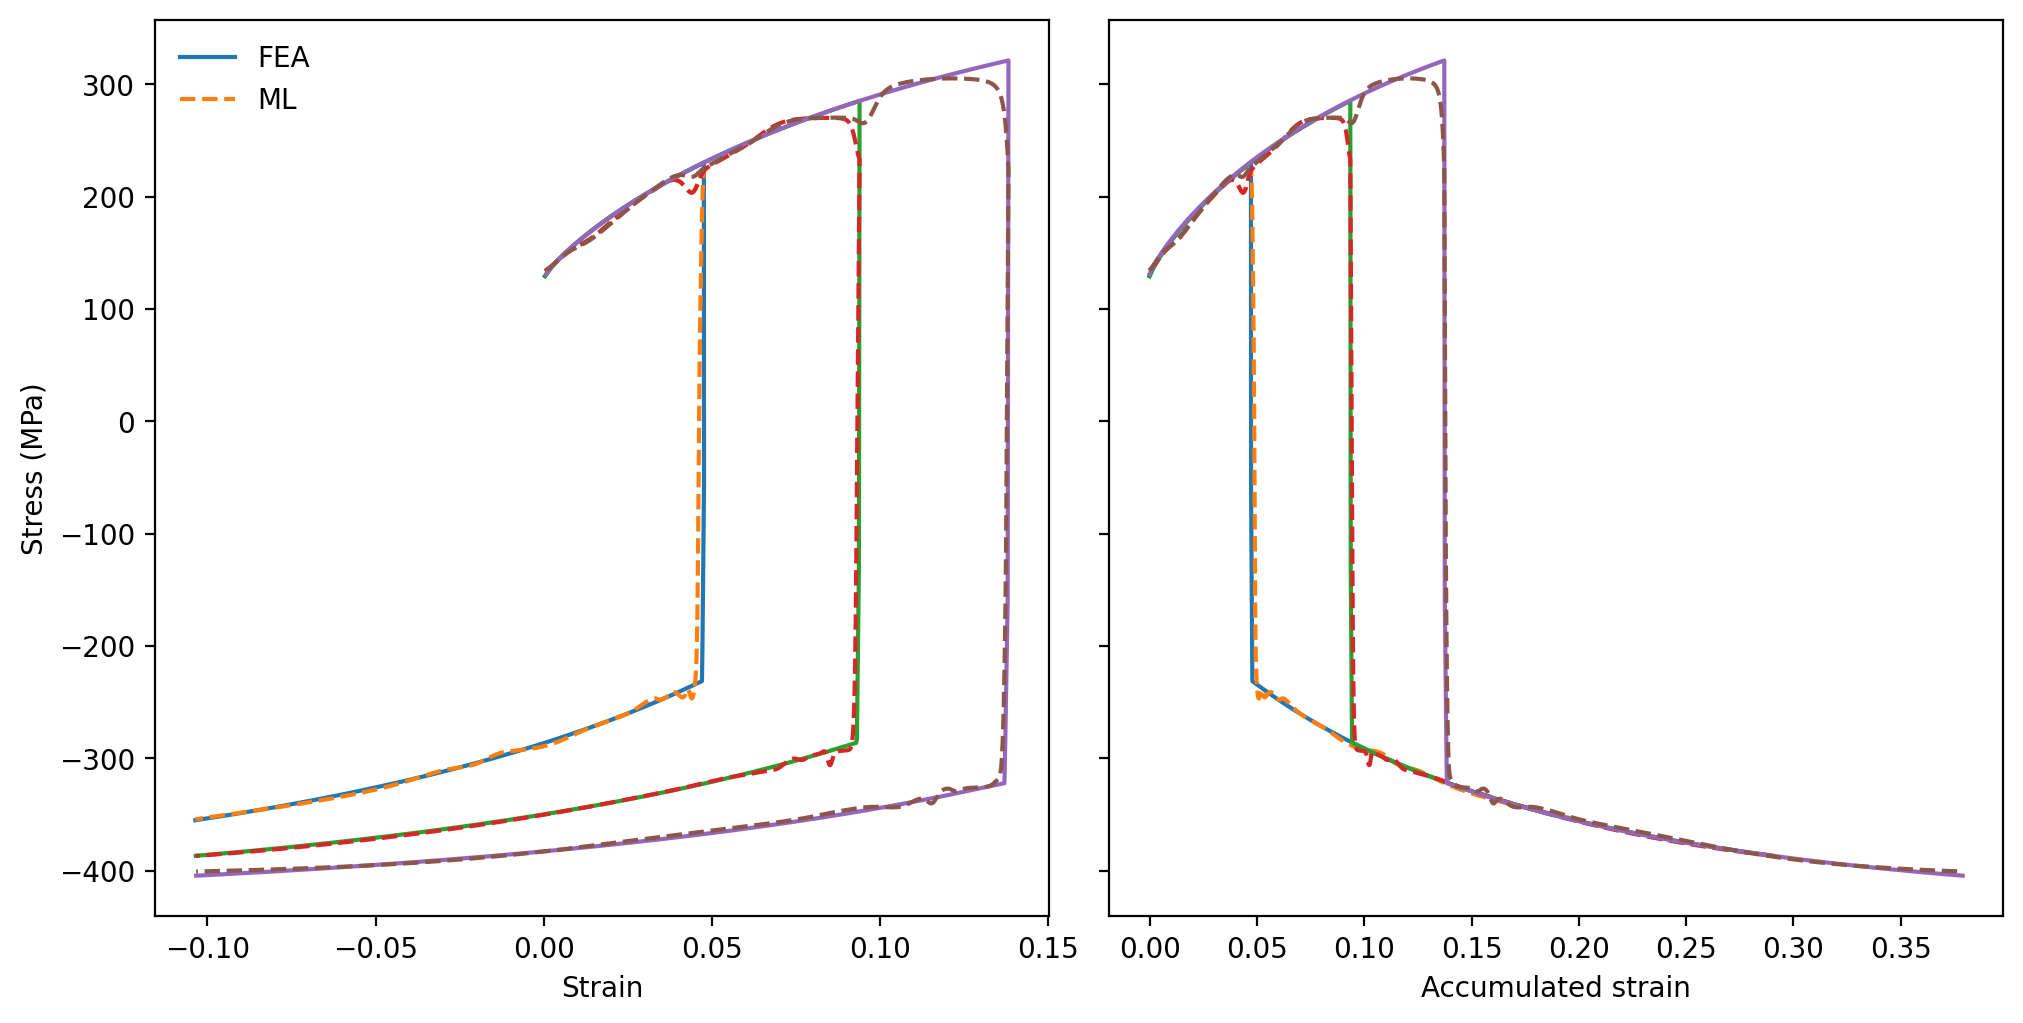

In [26]:
model.eval()

strain_eval = np.vstack((strain, strain_sum)).T
X_eval = torch.tensor(strain_eval, dtype=torch.float32)
with torch.no_grad():
    stress_ML = model(X_eval.to(device)).cpu().numpy()

npt = 1000*2
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
for i in range(0, 6001, npt):
    axs[0].plot(strain[i: i+npt], stress[i:i+npt], label='FEA', ls='-')
    axs[0].plot(strain[i: i+npt], stress_ML[i:i+npt], label='ML', ls='--')
    axs[1].plot(strain_sum[i:i+npt], stress[i:i+npt], label='FEA', ls='-')
    axs[1].plot(strain_sum[i:i+npt], stress_ML[i:i+npt], label='ML', ls='--')

axs[0].set_xlabel('Strain')
axs[0].set_ylabel('Stress (MPa)')
axs[1].set_xlabel('Accumulated strain')

labels, handles = axs[0].get_legend_handles_labels()
axs[0].legend(labels[:2], handles[:2], frameon=False)



In [27]:
torch.save(model.state_dict(), 'FCNN_J2.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'test_loss': test_loss,
    }, 'FCNN_J2.tar')
print('Saved model state to FCNN_J2.pth')

Saved model state to FCNN_J2.pth


In [36]:
def test2(X, y, model, loss_fn):
    print(X.shape)
    print(max(X[:,0]), min(X[:,0]))
    print(max(X[:,1]), min(X[:,1]))
    size = len(X)
    model.eval()
    # test_loss = 0
    X_batch = torch.tensor(X, dtype=torch.float32)
    y_batch = torch.tensor(y, dtype=torch.float32)
    with torch.no_grad():
        pred = model(X_batch.to(device))
        test_loss = loss_fn(pred, y_batch.to(device)).item()
    print('input y: ', max(y_batch), min(y_batch))
    print('pred y: ', max(pred), min(pred))
    print(len(y_batch), len(pred))
    print((y_batch-pred.to('cpu')).sum()/len(y_batch))
    # test_loss /= size
    print(f'Test loss: {test_loss:>8f} \n')
    return test_loss

x_train, x_test, y_train, y_test = train_test_split(strain_inp, stress, train_size=0.8)
print(test2(x_test, y_test, model, loss_fn))



(1200, 2)
0.1374767127713898 -0.10359362312051285
0.378346890574073 9.466982146203503e-05
input y:  tensor(320.7131) tensor(-404.4230)
pred y:  tensor([305.1846], device='cuda:0') tensor([-400.7446], device='cuda:0')
1200 1200
tensor(1279.4929)
Test loss: 159634.359375 

159634.359375


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1200])) that is different to the input size (torch.Size([1200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### GRU + FCNN model

In [ ]:
import torch
import torch.nn as nn

class GRU_FCNN(nn.Module):
    def __init__(self, input_size, gru_hidden_size, num_gru_layers, fcnn_hidden_sizes, output_size, dropout_prob=0.0):
        super(GRU_FCNN, self).__init__()
        self.gru = nn.GRU(input_size, gru_hidden_size, num_gru_layers, batch_first=True, dropout=dropout_prob)
        self.fcnn_layers = nn.ModuleList()

        # Add FCNN layers
        input_fcnn_size = gru_hidden_size
        for hidden_size in fcnn_hidden_sizes:
            self.fcnn_layers.append(nn.Linear(input_fcnn_size, hidden_size))
            self.fcnn_layers.append(nn.ReLU())
            input_fcnn_size = hidden_size

        self.fcnn_layers.append(nn.Linear(input_fcnn_size, output_size))

    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)

        # Take the output from the last time step
        fcnn_in = gru_out[:, -1, :]

        # FCNN layers
        for layer in self.fcnn_layers:
            fcnn_in = layer(fcnn_in)

        return fcnn_in